  state   stop_date stop_time  county_name driver_gender driver_race  \
0    RI  2005-01-04     12:55          NaN             M       White   
1    RI  2005-01-23     23:15          NaN             M       White   
2    RI  2005-02-17     04:15          NaN             M       White   
3    RI  2005-02-20     17:15          NaN             M       White   
4    RI  2005-02-24     01:20          NaN             F       White   

                    violation_raw  violation  search_conducted search_type  \
0  Equipment/Inspection Violation  Equipment             False         NaN   
1                        Speeding   Speeding             False         NaN   
2                        Speeding   Speeding             False         NaN   
3                Call for Service      Other             False         NaN   
4                        Speeding   Speeding             False         NaN   

    stop_outcome is_arrested stop_duration  drugs_related_stop district  
0       Citation       F

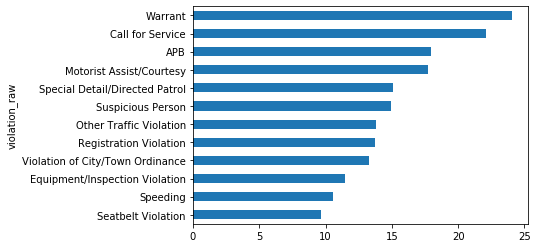

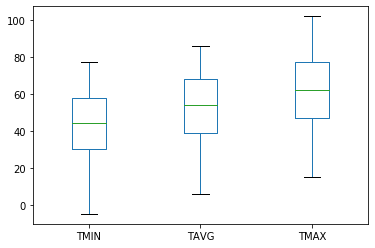

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


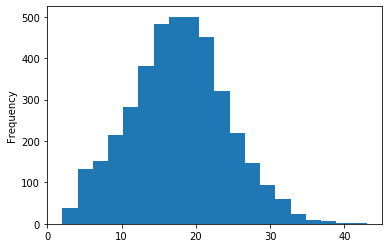

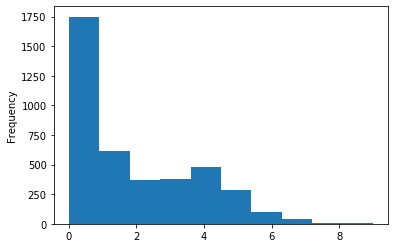

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
bad      1836
good     1749
worse     432
Name: rating, dtype: int64
        stop_datetime state   stop_date stop_time  county_name driver_gender  \
0 2005-01-04 12:55:00    RI  2005-01-04     12:55          NaN             M   
1 2005-01-23 23:15:00    RI  2005-01-23     23:15          NaN             M   
2 2005-02-17 04:15:00    RI  2005-02-17     04:15          NaN             M   
3 2005-02-20 17:15:00    RI  2005-02-20     17:15          NaN             M   
4 2005-02-24 01:20:00    RI  2005-02-24     01:20          NaN             F   

  driver_race                   violation_raw  violation  search_conducted  \
0       White  Equipment/Inspection Violation  Equipment             False   
1       White                        Speeding   Speeding             False   
2       White                        Speeding   Speeding             False   
3  

In [51]:
# import pandas as pd
ri=pd.read_csv('police.csv')
ri.columns
print(ri.head())
print(ri.isnull().sum())
print(ri.shape)

print(ri.isnull().sum())
ri.dropna(subset=['driver_gender'],inplace=True)
ri.dtypes

combined=ri.stop_date.str.cat(ri.stop_time,sep=' ')  #combined two columns together
ri['stop_datetime']=pd.to_datetime(combined)   #convert to datetime
ri.set_index('stop_datetime',inplace=True)  #set this new column as the index


#create a dateframe of female
female=ri[ri.driver_gender=='F']
#male
male=ri[ri.driver_gender=='M']
#proportions of violation for two genders
print(female.violation.value_counts(normalize=True))
print(male.violation.value_counts(normalize=True))


#dataframe for female speeding
female_and_speed=ri[(ri.driver_gender=='F')&(ri.violation=='Speeding')]
print(female_and_speed.stop_outcome.value_counts(normalize=True))

#search rate  by value_counts/mean since search_conducted is a boolean
print(ri.search_conducted.value_counts(normalize=True))
print(ri.search_conducted.mean())

#compare the two genders'search rate
print(ri.groupby(['driver_gender']).search_conducted.mean())

#search_type values
print(ri.search_type.value_counts())
#see if 'search_type' has a string 'Protective frisk'
ri['frisk']=ri.search_type.str.contains('Protective Frisk',
                                       na=False)  #na value will be assigned as False in this case

print(ri.frisk.dtype)
print(ri.frisk.sum())


searched=ri[ri.search_conducted==True]
print(searched.frisk.mean())  #percentage of frisk
print(searched.groupby(['driver_gender']).frisk.mean())  #see the percentage of frisk by gender


#change duration from time slot to a specific time
print(ri.stop_duration.unique())
mapping={'0-15 Min':8, '16-30 Min':23,'30+ Min':45}
ri['stop_minutes']=ri.stop_duration.map(mapping)
print(ri.stop_minutes.unique())

stop_length=ri.groupby('violation_raw').stop_minutes.mean()
stop_length.sort_values().plot(kind='barh')
plt.show()

#Does weather influence police's searching behavior?
weather=pd.read_csv('weather.csv')
weather[['TMIN','TAVG','TMAX']].plot(kind='box')
plt.show()

weather['TDIFF']=weather.TMAX-weather.TMIN
print(weather['TDIFF'].describe())
weather.TDIFF.plot(kind='hist',bins=20)
plt.show()

#bad weather distribution
WT=weather.loc[:,'WT01':'WT22']  #all kinds of bad weathers
#calculate the sum of each row in 'WT'
weather['bad_conditions']=WT.sum(axis='columns')
#replace missing values with 0
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')
weather.bad_conditions.plot(kind='hist')
plt.show()

# Count the unique values in 'bad_conditions' and sort the index
print(weather.bad_conditions.value_counts().sort_index())
# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad',4:'bad',5:'worse',
    6:'worse',7:'worse',8:'worse',9:'worse'}
# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(weather.rating.value_counts())

# Create a list of weather ratings in logical order
cats=['good','bad','worse']

# Change the data type of 'rating' to category
weather['rating'] = weather.rating.astype('category', order=True, category=cats)

# Reset the index of 'ri'
ri.reset_index(inplace=True)

# Examine the head of 'ri'
print(ri.head())

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating= weather[['DATE','rating']]
print(weather_rating.head())
# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')
print(ri_weather.columns)
# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('stop_datetime', inplace=True)

# the arrest rate for each 'violation' and 'rating'
arrest_rate=ri_weather.groupby(['violation','rating']).is_arrested
print(arrest_rate)

